# BGS SV QA

## Load the Spectro Catalog Database

Start by configuring the database, then load exposures, truth, targets, fiberassign, and the redshift catalog.

In [75]:
import importlib
import desispec.database.redshift


importlib.reload(desispec.database.redshift)

<module 'desispec.database.redshift' from '/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desispec/master/py/desispec/database/redshift.py'>

In [177]:
import os

from argparse                   import Namespace

from desispec.database.redshift import (setup_db, dbSession, load_file, ObsList, Target, Truth, ZCat, FiberAssign,
                                        load_fiberassign, update_truth)

basedir      = '/global/cscratch1/sd/mjwilson/minitest-19.2/'
targetdir    = '/global/cscratch1/sd/mjwilson/minitest-19.2/targets/'
reduxdir     = '/global/cscratch1/sd/mjwilson/minitest-19.2/spectro/redux/mini/'
expfile      = '/global/cscratch1/sd/mjwilson/minitest-19.2/survey/exposures.fits'
fibassigndir = '/global/cscratch1/sd/mjwilson/minitest-19.2/fiberassign/'

options      = Namespace(overwrite=True, dbfile=os.path.join(basedir, 'minitest.db'), hostname=None, maxrows=2000,
                         chunksize=50000, schema=None, username=None, verbose=False, datapath=basedir)

# We'll be using a SQLite database, ignore the return value of setup_db.
postgresql = setup_db(options)

print('--- Loading exposure list')
load_file(expfile, ObsList, hdu='EXPOSURES', expand={'PASS': 'passnum'})

print('--- Loading truth tables')
load_file(os.path.join(targetdir, 'truth.fits'), Truth, hdu='TRUTH')

for h in ('BGS', 'ELG', 'LRG', 'QSO', 'STAR', 'WD'):
    update_truth(os.path.join(targetdir, 'truth.fits'), 'TRUTH_' + h)

print('--- Loading targets')

load_file(os.path.join(targetdir, 'targets.fits'), Target, hdu='TARGETS',
          expand={'DCHISQ': ('dchisq_psf', 'dchisq_rex', 'dchisq_dev', 'dchisq_exp', 'dchisq_comp',)})

print('--- loading redshift catalog')
load_file(os.path.join(reduxdir, 'zcatalog-mini.fits'), ZCat, hdu='ZCATALOG',
          expand={'COEFF': ('coeff_0', 'coeff_1', 'coeff_2', 'coeff_3', 'coeff_4',
                            'coeff_5', 'coeff_6', 'coeff_7', 'coeff_8', 'coeff_9',)},
          rowfilter=lambda x: ((x['TARGETID'] != 0) & (x['TARGETID'] != -1)))

print('--- loading fiber assignments')
load_fiberassign(fibassigndir)

print('--- done')

INFO:redshift.py:803:setup_db: Removing file: /global/cscratch1/sd/mjwilson/minitest-19.2/minitest.db.
INFO:redshift.py:812:setup_db: Begin creating tables.
INFO:redshift.py:816:setup_db: Finished creating tables.
--- Loading exposure list
INFO:redshift.py:365:load_file: Read data from /global/cscratch1/sd/mjwilson/minitest-19.2/survey/exposures.fits HDU EXPOSURES
INFO:redshift.py:383:load_file: Integrity check complete on obslist.
INFO:redshift.py:391:load_file: Initial column conversion complete on obslist.
INFO:redshift.py:413:load_file: Column expansion complete on obslist.
INFO:redshift.py:419:load_file: Column conversion complete on obslist.
INFO:redshift.py:426:load_file: Converted columns into rows on obslist.
INFO:redshift.py:433:load_file: Inserted 45 rows in obslist.
--- Loading truth tables
INFO:redshift.py:365:load_file: Read data from /global/cscratch1/sd/mjwilson/minitest-19.2/targets/truth.fits HDU TRUTH
INFO:redshift.py:383:load_file: Integrity check complete on truth.

### Demonstrate the SQLAlchemy objects

In [77]:
# tt = dbSession.query(Truth, Target).filter(Truth.targetid == Target.targetid).all()

In [78]:
# zz = dbSession.query(Truth, ZCat).filter(Truth.targetid == ZCat.targetid).all()

In [190]:
# ff = dbSession.query(Truth, FiberAssign).filter(Truth.targetid == FiberAssign.targetid).all()

In [191]:
# How many actual exposures are there with the Moon up?
# q = dbSession.query(ObsList.expid, ObsList.moonsep, ObsList.moonalt, ObsList.moonfrac).filter(ObsList.moonalt > 0).all()

In [200]:
'''
q = dbSession.query(ZCat.targetid, Target.desi_target, Target.bgs_target, Target.mws_target, ObsList.expid)\
             .filter(ZCat.targetid      == FiberAssign.targetid)\
             .filter(ZCat.targetid      == Target.targetid)\
             .filter(FiberAssign.tileid == ObsList.tileid)\
             .filter(ObsList.expid.in_(expid))\
             .order_by(ZCat.targetid, ObsList.expid).all()

targetid, desi_target, bgs_target, mws_target, expid = zip(*q)
'''

'\nq = dbSession.query(ZCat.targetid, Target.desi_target, Target.bgs_target, Target.mws_target, ObsList.expid)             .filter(ZCat.targetid      == FiberAssign.targetid)             .filter(ZCat.targetid      == Target.targetid)             .filter(FiberAssign.tileid == ObsList.tileid)             .filter(ObsList.expid.in_(expid))             .order_by(ZCat.targetid, ObsList.expid).all()\n\ntargetid, desi_target, bgs_target, mws_target, expid = zip(*q)\n'

In [201]:
'''
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)


print(sum(['ELG'     in desi_mask.names(t) for t in desi_target]))
print(sum(['BGS_ANY' in desi_mask.names(t) for t in desi_target]))
print(sum(['BGS_ANY' in  bgs_mask.names(t) for t in  bgs_target]))
'''

"\nfrom desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)\n\n\nprint(sum(['ELG'     in desi_mask.names(t) for t in desi_target]))\nprint(sum(['BGS_ANY' in desi_mask.names(t) for t in desi_target]))\nprint(sum(['BGS_ANY' in  bgs_mask.names(t) for t in  bgs_target]))\n"

In [202]:
q = dbSession.query(ZCat.targetid, Truth.truez, ZCat.z, ZCat.zwarn, Target.fiberflux_r, ((ZCat.z - Truth.truez)/(1.0 + Truth.truez)).label('dz'))\
                   .filter(Truth.targetid     == ZCat.targetid)\
                   .filter(Target.targetid    == ZCat.targetid)\
                   .filter(ZCat.targetid      == FiberAssign.targetid)\
                   .filter(FiberAssign.tileid == ObsList.tileid)\
                   .filter(ObsList.expid.in_(expid))\
                   .filter(Target.desi_target.op('&')(desi_mask.BGS_ANY) != 0)\
                   .all()

_, truez, z, zwarn, fiberflux, dz = zip(*q)

z     = np.array(z)
truez = np.array(truez)
zwarn = np.array(zwarn)

##  binned fiber flux. 
bins     = np.arange(0.0, 5., 1.)
nbins    = len(bins)

bnd_ffux = np.digitize(fiberflux, bins, right=False)

In [203]:
# What warnings were there?
print(np.unique(zwarn, return_counts=True))

(array([   0,    4, 1060]), array([25234,   724,     2]))


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5,0.98,'Fiber flux')

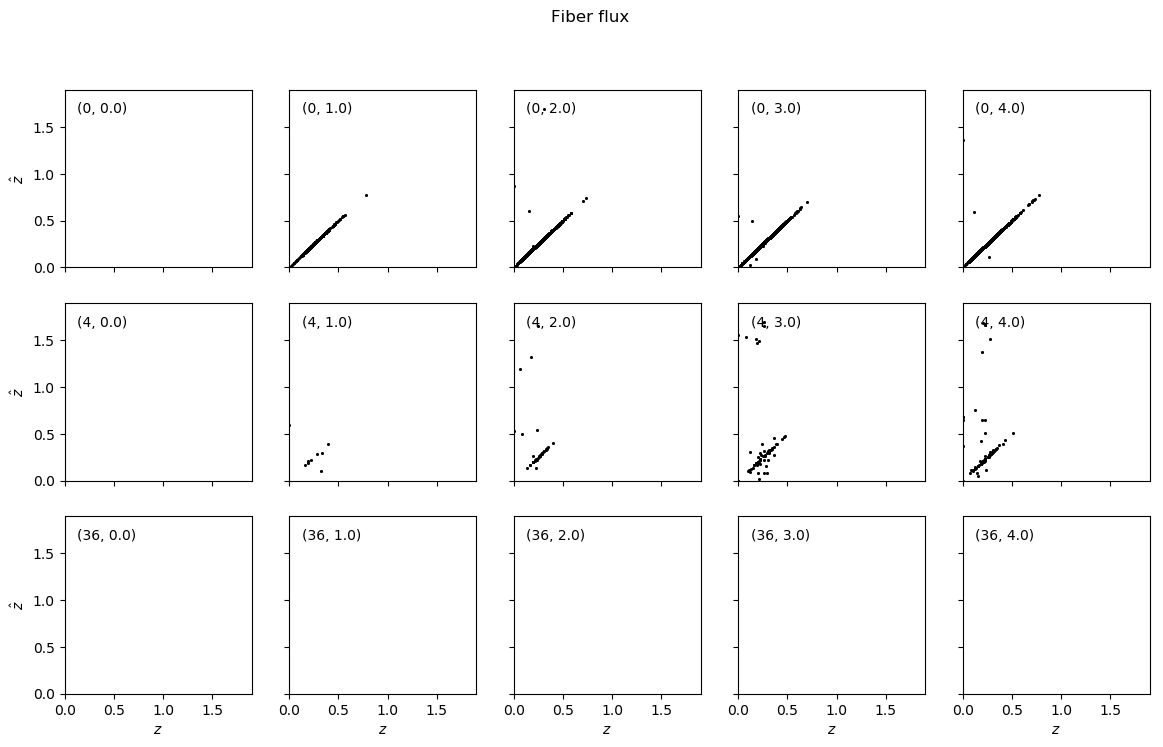

In [204]:
import matplotlib.pyplot as plt


# Observed redshift versus true redshift.
fig, axes = plt.subplots(3, nbins, figsize=(14, 8), dpi=100, sharey = True, sharex=True)

for i, _zwarn in enumerate([0, 4, 36]):
 for j, lolim in enumerate(bins):
  axes[i][j].plot(truez[(zwarn == _zwarn) & (bnd_ffux == j)], z[(zwarn == _zwarn) & (bnd_ffux == j)], 'ko', label='', markersize=1)

  axes[i][j].set_xlim(0.0, 1.9)
  axes[i][j].set_ylim(0.0, 1.9)
    
  axes[i][j].legend(loc=2, frameon=False, title='(%d, %.1lf)' % (_zwarn, bins[j]))
    
axes[0][0].set_ylabel(r'$\hat z$')
axes[1][0].set_ylabel(r'$\hat z$')
axes[2][0].set_ylabel(r'$\hat z$')

axes[2][0].set_xlabel(r'$z$')
axes[2][1].set_xlabel(r'$z$')
axes[2][2].set_xlabel(r'$z$')    
axes[2][3].set_xlabel(r'$z$')    
axes[2][4].set_xlabel(r'$z$')    

fig.suptitle('Fiber flux')

In [86]:
# Print the table columns and their types.
[(c.name, c.type) for c in ZCat.__table__.columns]

[('targetid', BigInteger()),
 ('chi2', Float()),
 ('coeff_0', Float()),
 ('coeff_1', Float()),
 ('coeff_2', Float()),
 ('coeff_3', Float()),
 ('coeff_4', Float()),
 ('coeff_5', Float()),
 ('coeff_6', Float()),
 ('coeff_7', Float()),
 ('coeff_8', Float()),
 ('coeff_9', Float()),
 ('z', Float()),
 ('zerr', Float()),
 ('zwarn', BigInteger()),
 ('npixels', BigInteger()),
 ('spectype', String()),
 ('subtype', String()),
 ('ncoeff', BigInteger()),
 ('deltachi2', Float()),
 ('brickname', String()),
 ('numexp', Integer()),
 ('numtile', Integer())]

In [205]:
# Print the table columns and their types.
[(c.name, c.type) for c in Target.__table__.columns]

[('release', Integer()),
 ('brickid', Integer()),
 ('brickname', String()),
 ('brick_objid', Integer()),
 ('morphtype', String()),
 ('ra', Float()),
 ('dec', Float()),
 ('ra_ivar', Float()),
 ('dec_ivar', Float()),
 ('dchisq_psf', Float()),
 ('dchisq_rex', Float()),
 ('dchisq_dev', Float()),
 ('dchisq_exp', Float()),
 ('dchisq_comp', Float()),
 ('flux_g', Float()),
 ('flux_r', Float()),
 ('flux_z', Float()),
 ('flux_w1', Float()),
 ('flux_w2', Float()),
 ('flux_ivar_g', Float()),
 ('flux_ivar_r', Float()),
 ('flux_ivar_z', Float()),
 ('flux_ivar_w1', Float()),
 ('flux_ivar_w2', Float()),
 ('mw_transmission_g', Float()),
 ('mw_transmission_r', Float()),
 ('mw_transmission_z', Float()),
 ('mw_transmission_w1', Float()),
 ('mw_transmission_w2', Float()),
 ('nobs_g', Integer()),
 ('nobs_r', Integer()),
 ('nobs_z', Integer()),
 ('fracflux_g', Float()),
 ('fracflux_r', Float()),
 ('fracflux_z', Float()),
 ('fracmasked_g', Float()),
 ('fracmasked_r', Float()),
 ('fracmasked_z', Float()),
 ('f

In [87]:
type(tt[0][0])

desispec.database.redshift.Truth

In [88]:
dir(tt[0][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'bal_templateid',
 'd4000',
 'ewhbeta',
 'ewoii',
 'feh',
 'flux_g',
 'flux_r',
 'flux_w1',
 'flux_w2',
 'flux_z',
 'hbetaflux',
 'logg',
 'mabs_1450',
 'mag',
 'magfilter',
 'metadata',
 'mockid',
 'niihbeta',
 'oiidoublet',
 'oiiflux',
 'oiihbeta',
 'oiiihbeta',
 'seed',
 'siihbeta',
 'targetid',
 'teff',
 'templateid',
 'templatesubtype',
 'templatetype',
 'truespectype',
 'truez',
 'truez_norsd',
 'vdisp']

In [89]:
tt[0][0]

<Truth(targetid=288230398217945088)>

In [90]:
type(tt[0][1])

desispec.database.redshift.Target

In [91]:
dir(tt[0][1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'allmask_g',
 'allmask_r',
 'allmask_z',
 'bgs_target',
 'brick_objid',
 'brickid',
 'brickname',
 'brightstarinblob',
 'dchisq_comp',
 'dchisq_dev',
 'dchisq_exp',
 'dchisq_psf',
 'dchisq_rex',
 'dec',
 'dec_ivar',
 'desi_target',
 'ebv',
 'fiberflux_g',
 'fiberflux_r',
 'fiberflux_z',
 'fibertotflux_g',
 'fibertotflux_r',
 'fibertotflux_z',
 'flux_g',
 'flux_ivar_g',
 'flux_ivar_r',
 'flux_ivar_w1',
 'flux_ivar_w2',
 'flux_ivar_z',
 'flux_r',
 'flux_w1',
 'flux_w2',
 'flux_z',
 'fracdev

In [92]:
type(zz[0][0])

desispec.database.redshift.Truth

In [93]:
dir(zz[0][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'bal_templateid',
 'd4000',
 'ewhbeta',
 'ewoii',
 'feh',
 'flux_g',
 'flux_r',
 'flux_w1',
 'flux_w2',
 'flux_z',
 'hbetaflux',
 'logg',
 'mabs_1450',
 'mag',
 'magfilter',
 'metadata',
 'mockid',
 'niihbeta',
 'oiidoublet',
 'oiiflux',
 'oiihbeta',
 'oiiihbeta',
 'seed',
 'siihbeta',
 'targetid',
 'teff',
 'templateid',
 'templatesubtype',
 'templatetype',
 'truespectype',
 'truez',
 'truez_norsd',
 'vdisp']

In [94]:
type(zz[0][1])

desispec.database.redshift.ZCat

In [95]:
dir(zz[0][1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'brickname',
 'chi2',
 'coeff_0',
 'coeff_1',
 'coeff_2',
 'coeff_3',
 'coeff_4',
 'coeff_5',
 'coeff_6',
 'coeff_7',
 'coeff_8',
 'coeff_9',
 'deltachi2',
 'metadata',
 'ncoeff',
 'npixels',
 'numexp',
 'numtile',
 'spectype',
 'subtype',
 'targetid',
 'z',
 'zerr',
 'zwarn']

In [96]:
import numpy as np

np.unique(zz[0][1].zwarn, return_counts=True)

(array([0]), array([1]))

In [97]:
type(ff[0][0])

desispec.database.redshift.Truth

In [98]:
dir(ff[0][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'bal_templateid',
 'd4000',
 'ewhbeta',
 'ewoii',
 'feh',
 'flux_g',
 'flux_r',
 'flux_w1',
 'flux_w2',
 'flux_z',
 'hbetaflux',
 'logg',
 'mabs_1450',
 'mag',
 'magfilter',
 'metadata',
 'mockid',
 'niihbeta',
 'oiidoublet',
 'oiiflux',
 'oiihbeta',
 'oiiihbeta',
 'seed',
 'siihbeta',
 'targetid',
 'teff',
 'templateid',
 'templatesubtype',
 'templatetype',
 'truespectype',
 'truez',
 'truez_norsd',
 'vdisp']

In [99]:
type(ff[0][1])

desispec.database.redshift.FiberAssign

In [100]:
dir(ff[0][1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'bgs_target',
 'brickname',
 'desi_target',
 'design_q',
 'design_s',
 'design_x',
 'design_y',
 'device_loc',
 'fiber',
 'fiberstatus',
 'lambda_ref',
 'location',
 'metadata',
 'mws_target',
 'numtarget',
 'objtype',
 'petal_loc',
 'priority',
 'subpriority',
 'target_dec',
 'target_ra',
 'targetid',
 'tileid']

# QA

## Initialize QA output directory

In [101]:
import desispec

# New dir to define and make
qaprod_dir = desispec.io.qaprod_root()
os.makedirs(qaprod_dir, exist_ok=True)
qaprod_dir

'/global/project/projectdirs/desi/spectro/redux/mjwilson/QA'

In [102]:
#- Helper function for timing QA commands
def time_command(cmd, logfile):
    t0 = time.time()
    print('{} RUNNING {}'.format(time.asctime(), cmd))
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    if err != 0:
        print('FAILED: {}'.format(cmd))

    dt = time.time() - t0
    if dt < 60:
        print('"{}" took {:.1f} seconds'.format(cmd, time.time()-t0))
    else:
        print('"{}" took {:.1f} minutes'.format(cmd, dt/60))
    return err

### QA with the Truth

The following QA uses the input truth table.  

In [103]:
qat_logname = os.path.join(qaprod_dir, 'qa_truth.log')
print('logging truth-based QA to {}'.format(qat_logname))

logging truth-based QA to /global/project/projectdirs/desi/spectro/redux/mjwilson/QA/qa_truth.log


In [104]:
import time, glob, subprocess

qa0_time = time.time()

with open(qat_logname, 'w') as logfile:
    if len(glob.glob(qaprod_dir+'/QA_s2n_*')) == 10:
        print("S/N figures already exist")
        
    else:
        # S/N (~7min)
        cmd = "desi_qa_s2n --qaprod_dir={:s}".format(qaprod_dir)
        time_command(cmd, logfile)
    
    # zfind (~2min)
    if (len(glob.glob(qaprod_dir+'/QA_zfind_*')) == 6) and os.path.exists(qaprod_dir+'/QA_dzsumm.png'):
        print("zfind figures already exist")

    else:
        cmd = "desi_qa_zfind --yaml_file={:s}/dzsumm_stats.yaml --qaprod_dir={:s}".format(qaprod_dir, qaprod_dir) 
        time_command(cmd, logfile)
    
# Time me
print("Done with QA with truth at {}".format(time.asctime()))

qa_truth_time = time.time() - qa0_time

print("That took {:.1f} minutes".format(qa_truth_time/60))

S/N figures already exist
Thu May 16 21:47:35 2019 RUNNING desi_qa_zfind --yaml_file=/global/project/projectdirs/desi/spectro/redux/mjwilson/QA/dzsumm_stats.yaml --qaprod_dir=/global/project/projectdirs/desi/spectro/redux/mjwilson/QA
FAILED: desi_qa_zfind --yaml_file=/global/project/projectdirs/desi/spectro/redux/mjwilson/QA/dzsumm_stats.yaml --qaprod_dir=/global/project/projectdirs/desi/spectro/redux/mjwilson/QA
"desi_qa_zfind --yaml_file=/global/project/projectdirs/desi/spectro/redux/mjwilson/QA/dzsumm_stats.yaml --qaprod_dir=/global/project/projectdirs/desi/spectro/redux/mjwilson/QA" took 1.8 seconds
Done with QA with truth at Thu May 16 21:47:36 2019
That took 0.0 minutes


### Check

In [105]:
assert len(glob.glob(qaprod_dir+'/QA_s2n_*')) == 10
assert len(glob.glob(qaprod_dir+'/QA_zfind_*')) == 6
assert os.path.exists(qaprod_dir+'/QA_dzsumm.png')

AssertionError: 

### Show

In [106]:
from IPython.display import Image, display
Image(filename=qaprod_dir+'/QA_dzsumm.png') 

FileNotFoundError: [Errno 2] No such file or directory: '/global/project/projectdirs/desi/spectro/redux/mjwilson/QA/QA_dzsumm.png'

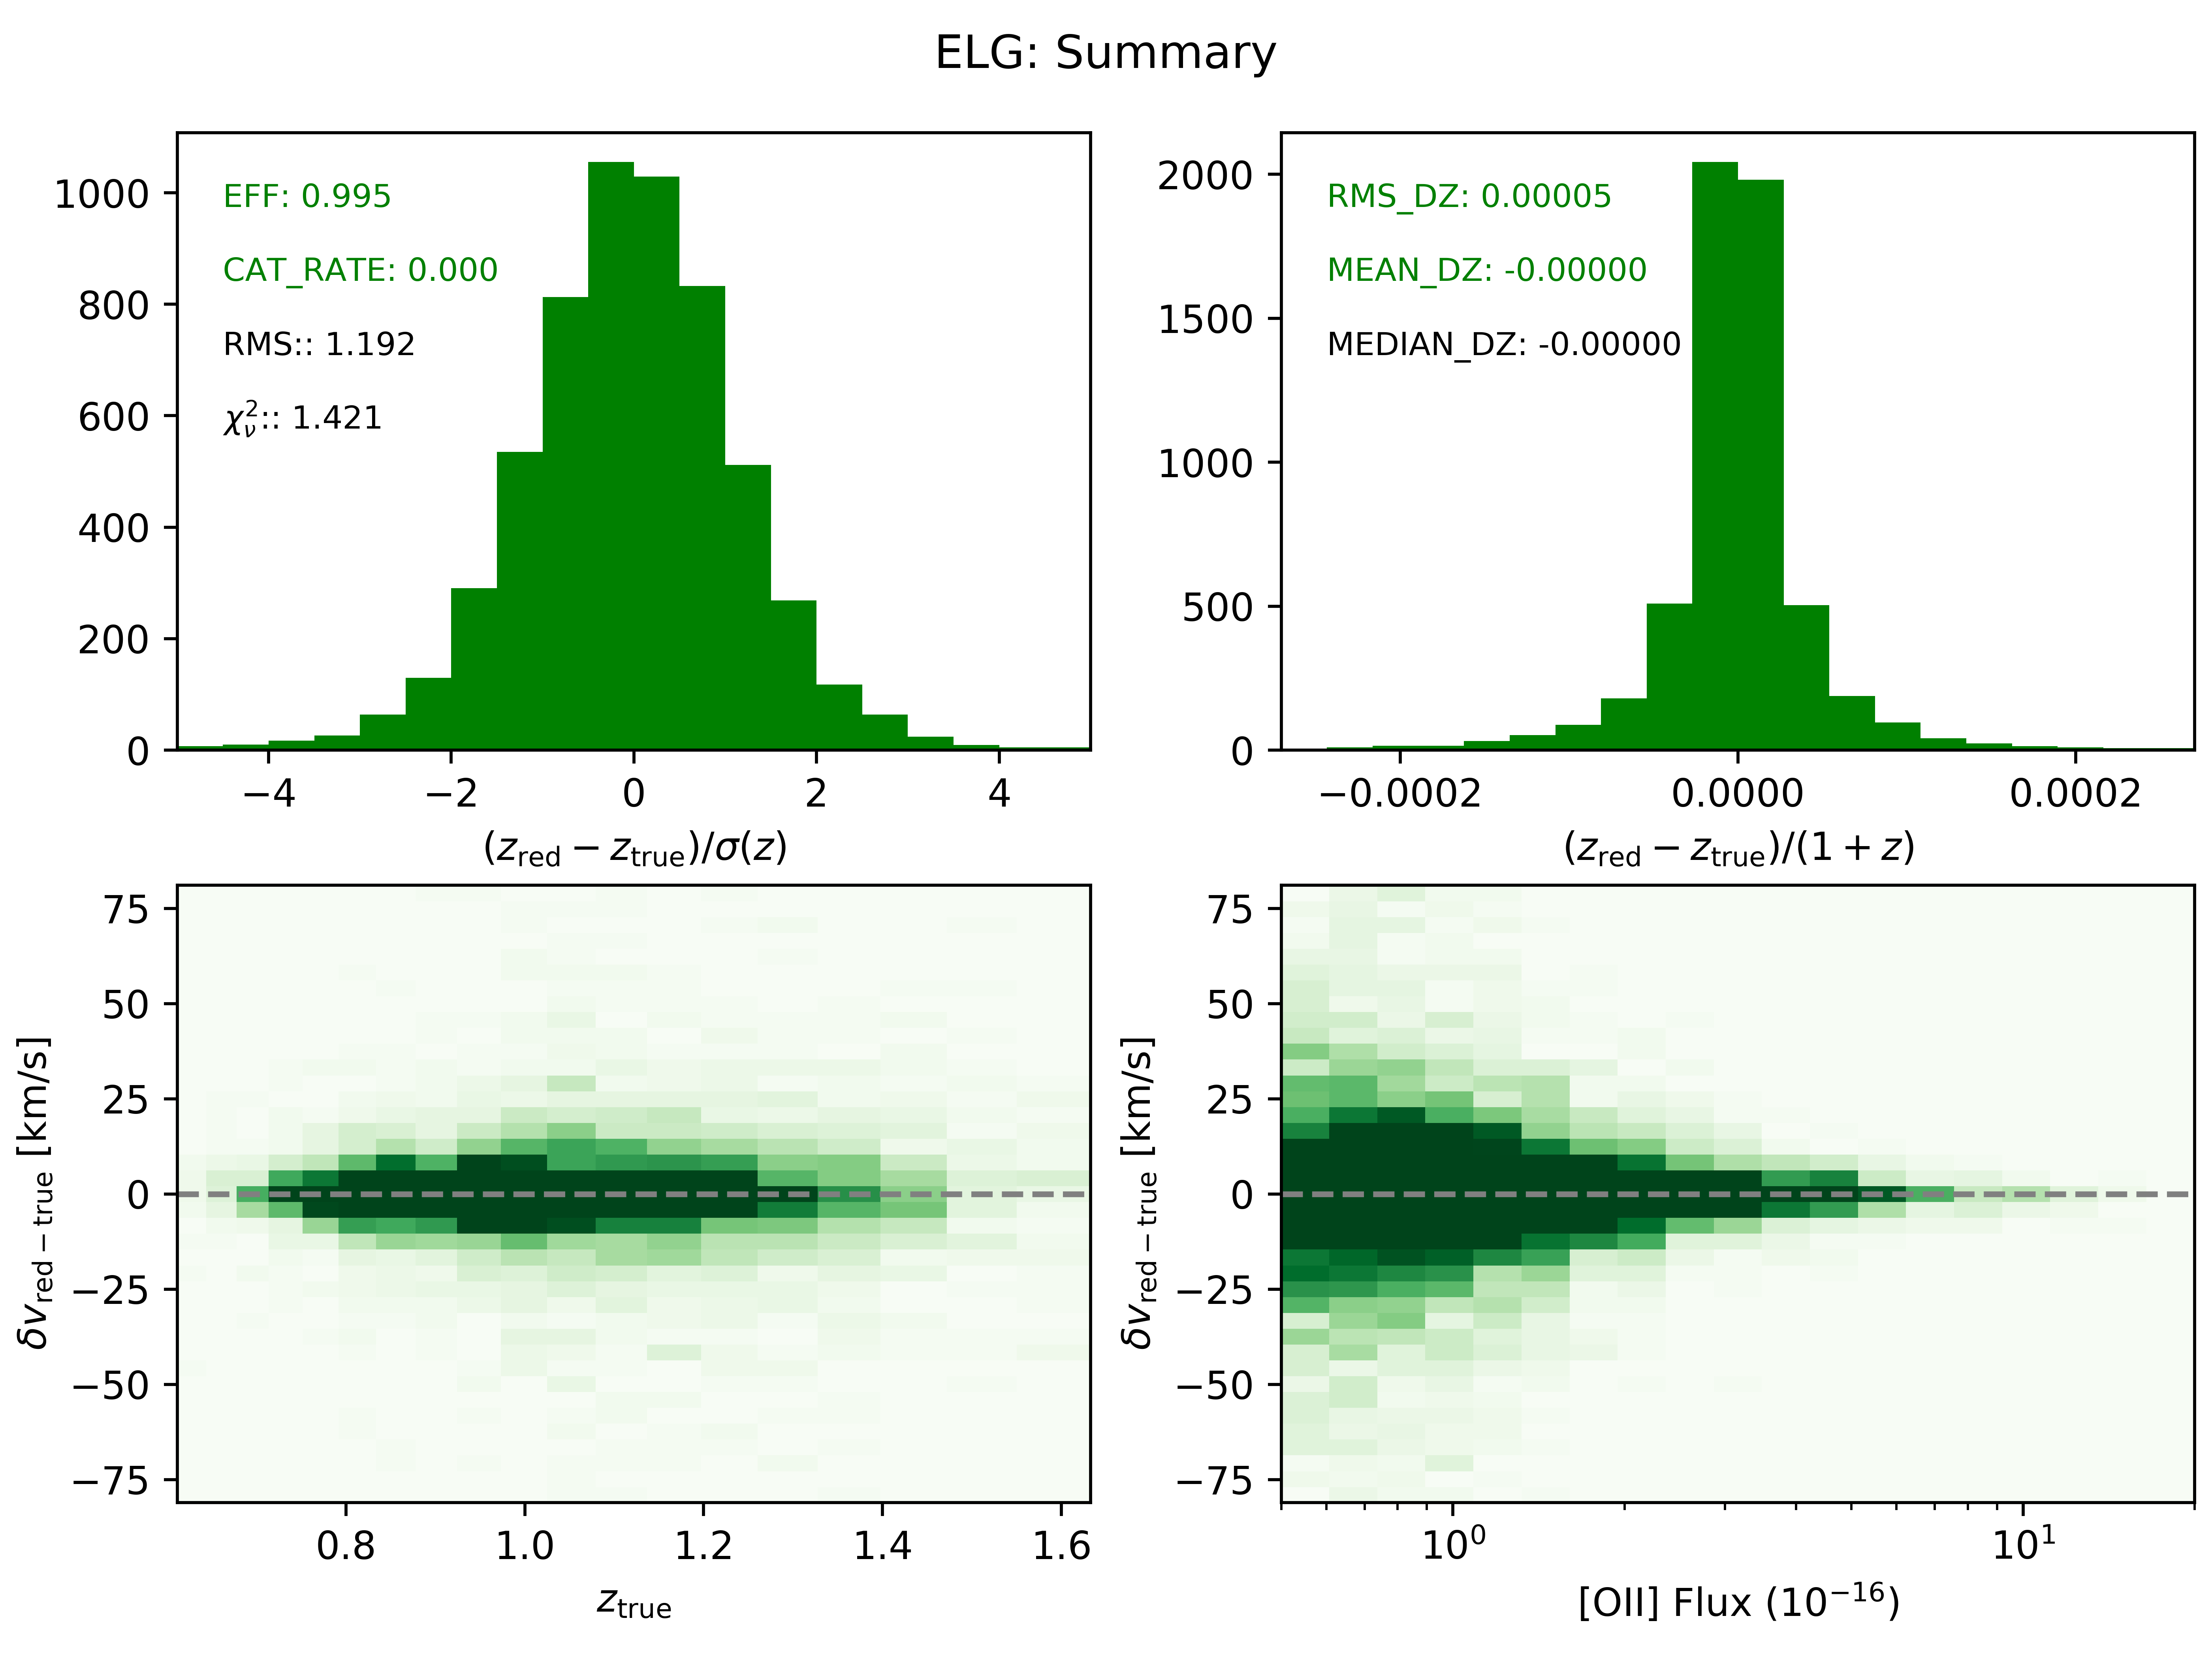

In [76]:
Image(filename=qaprod_dir+'/QA_zfind_ELG.png', width=500)

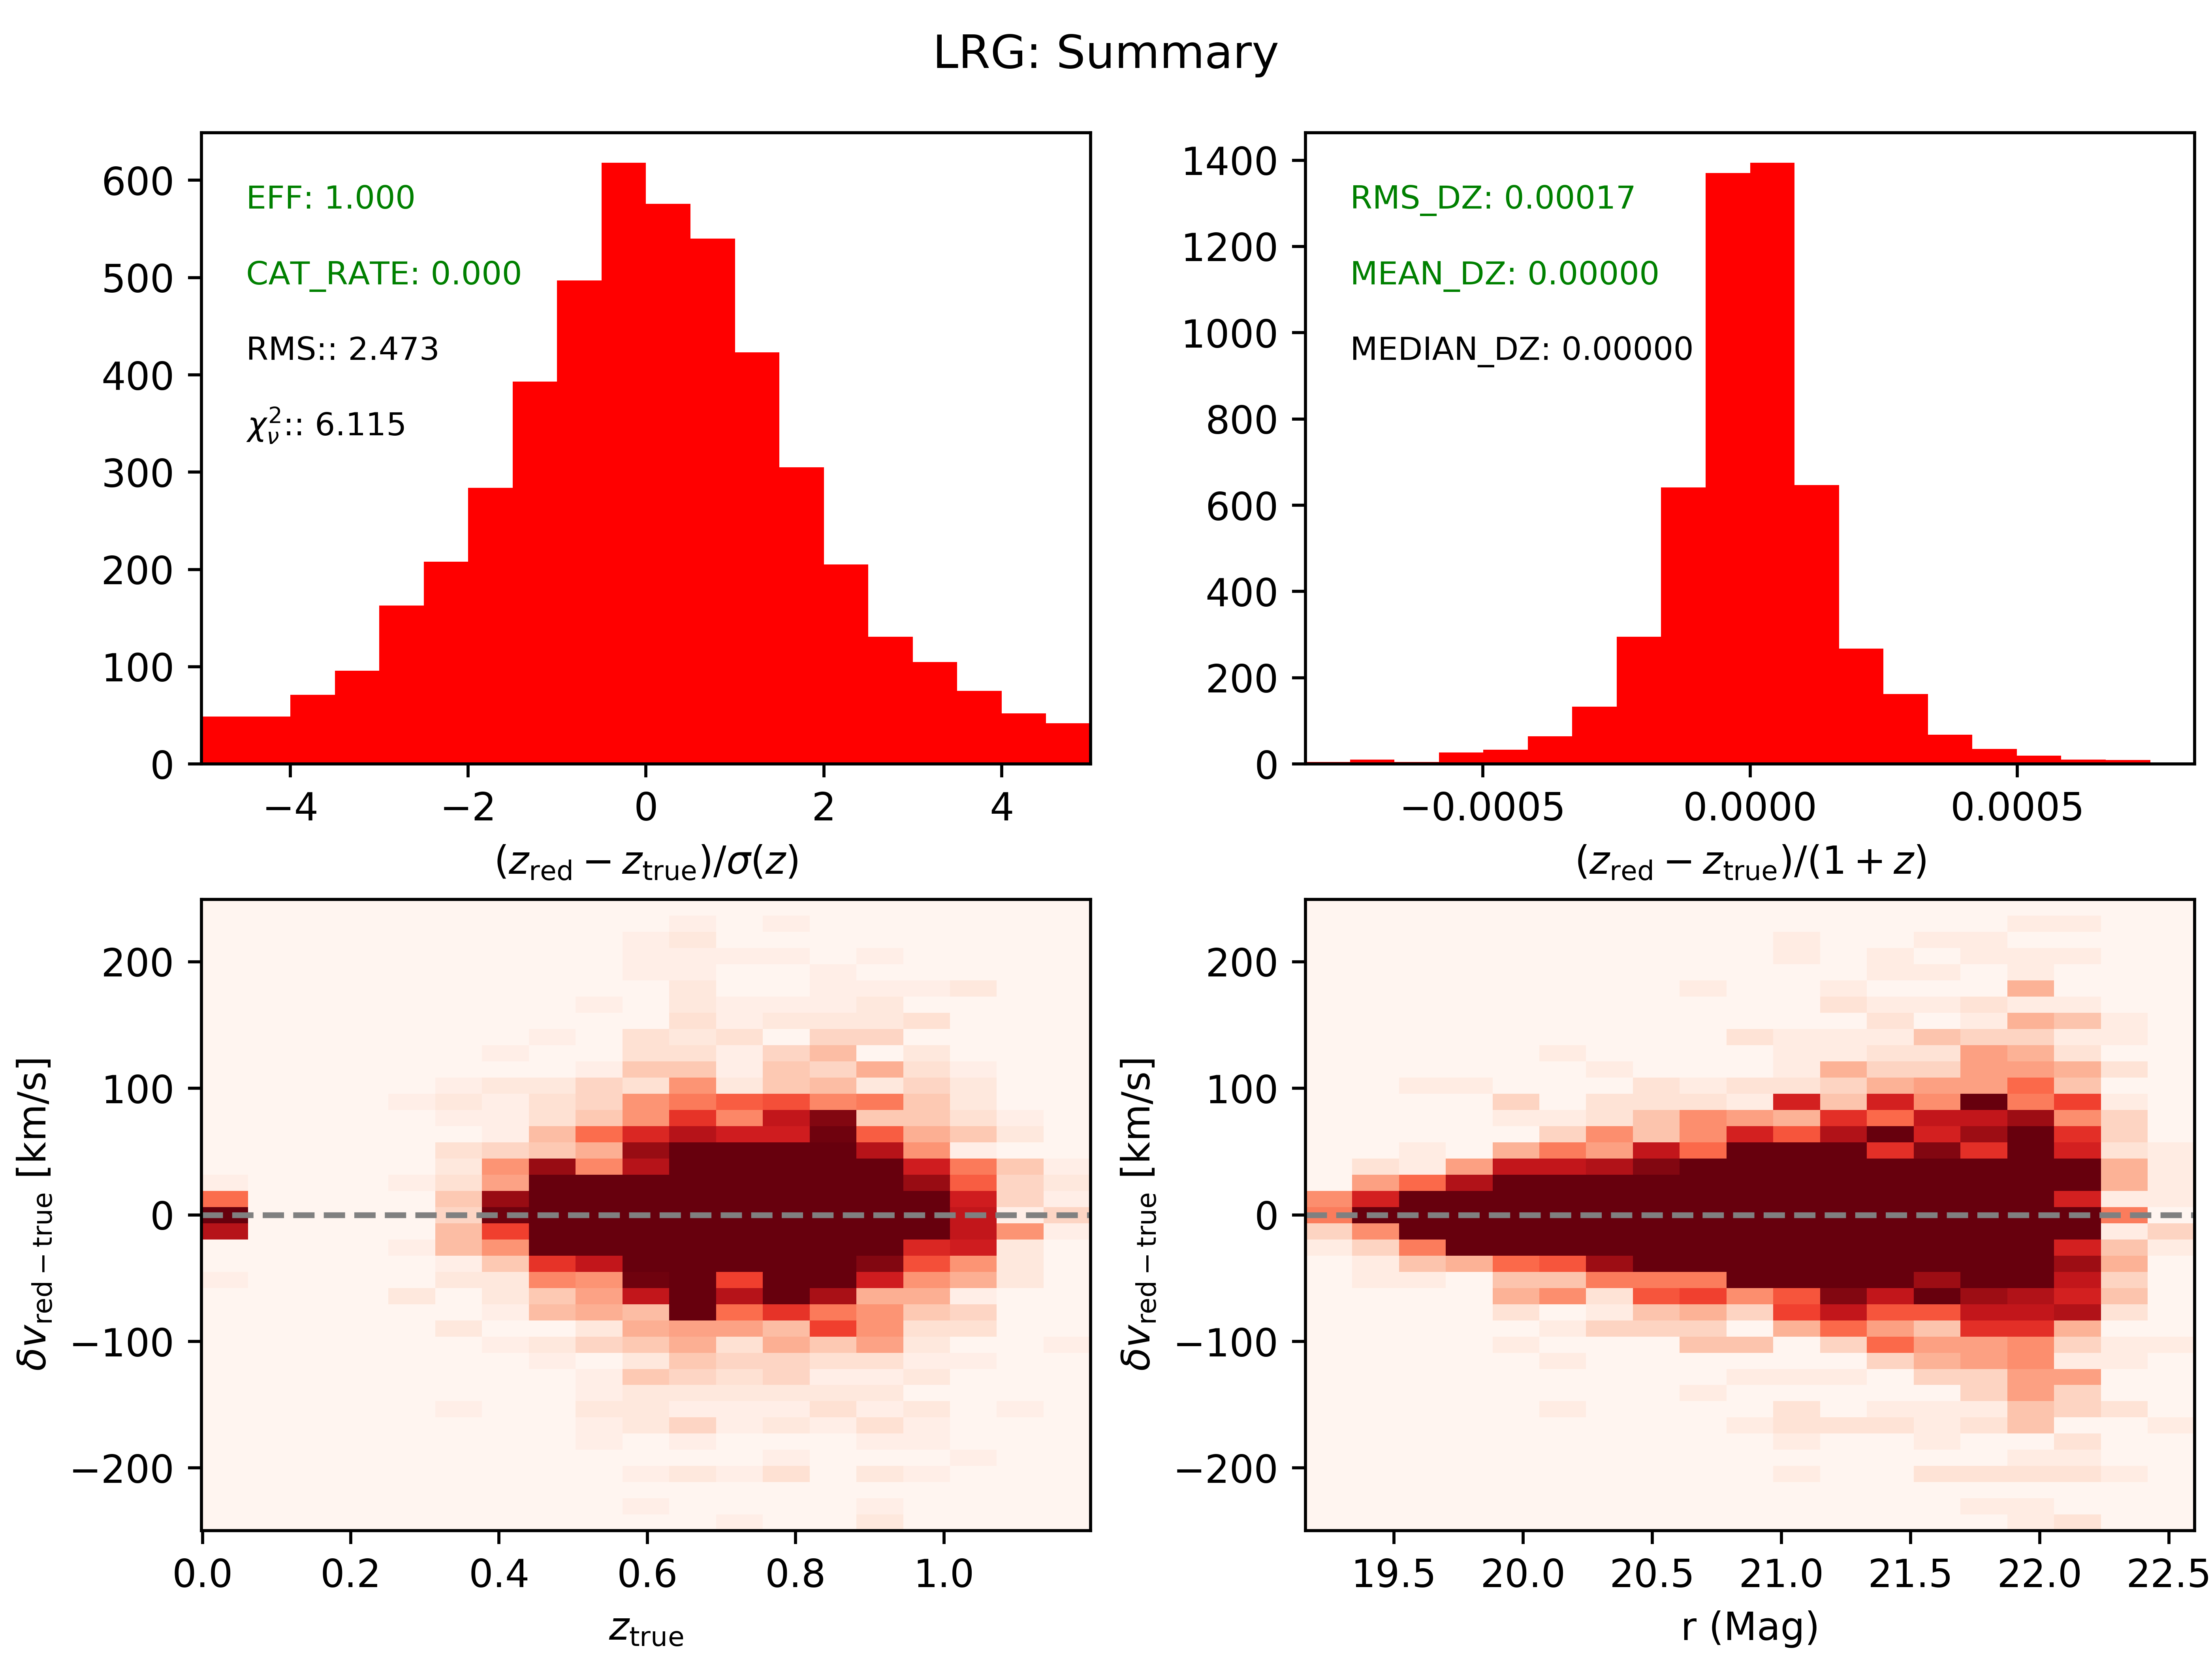

In [77]:
Image(filename=qaprod_dir+'/QA_zfind_LRG.png', width=500)

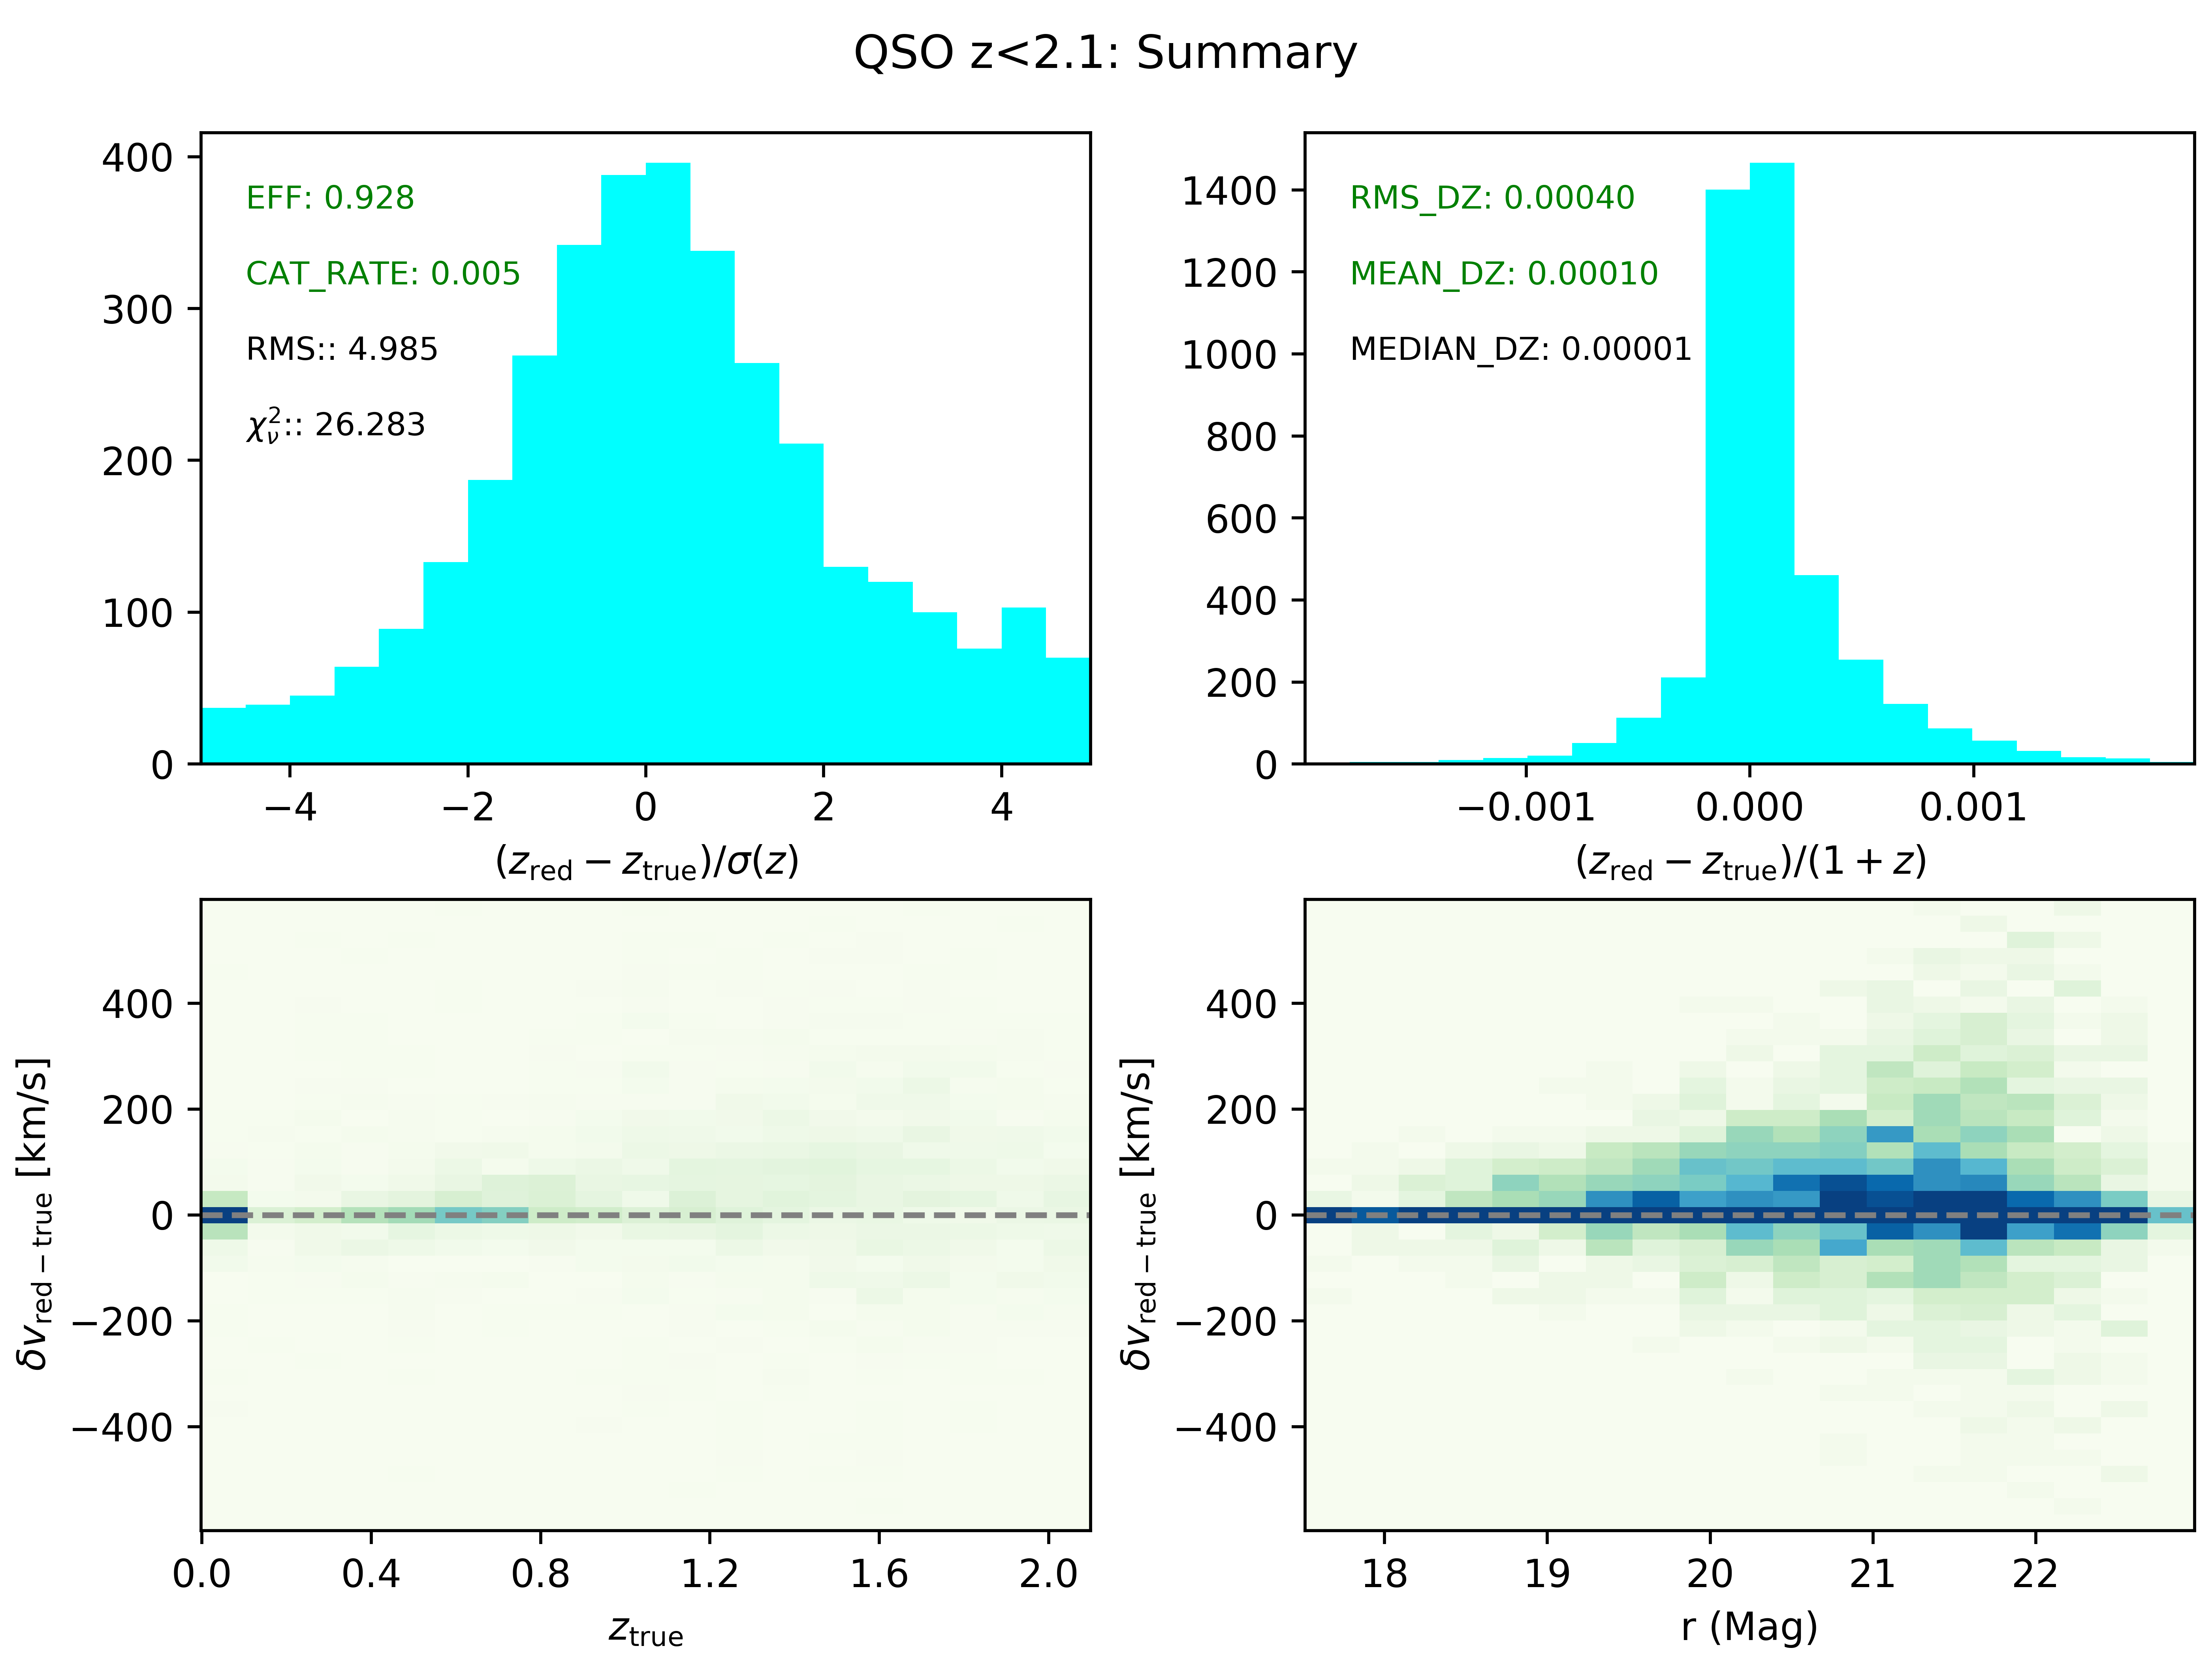

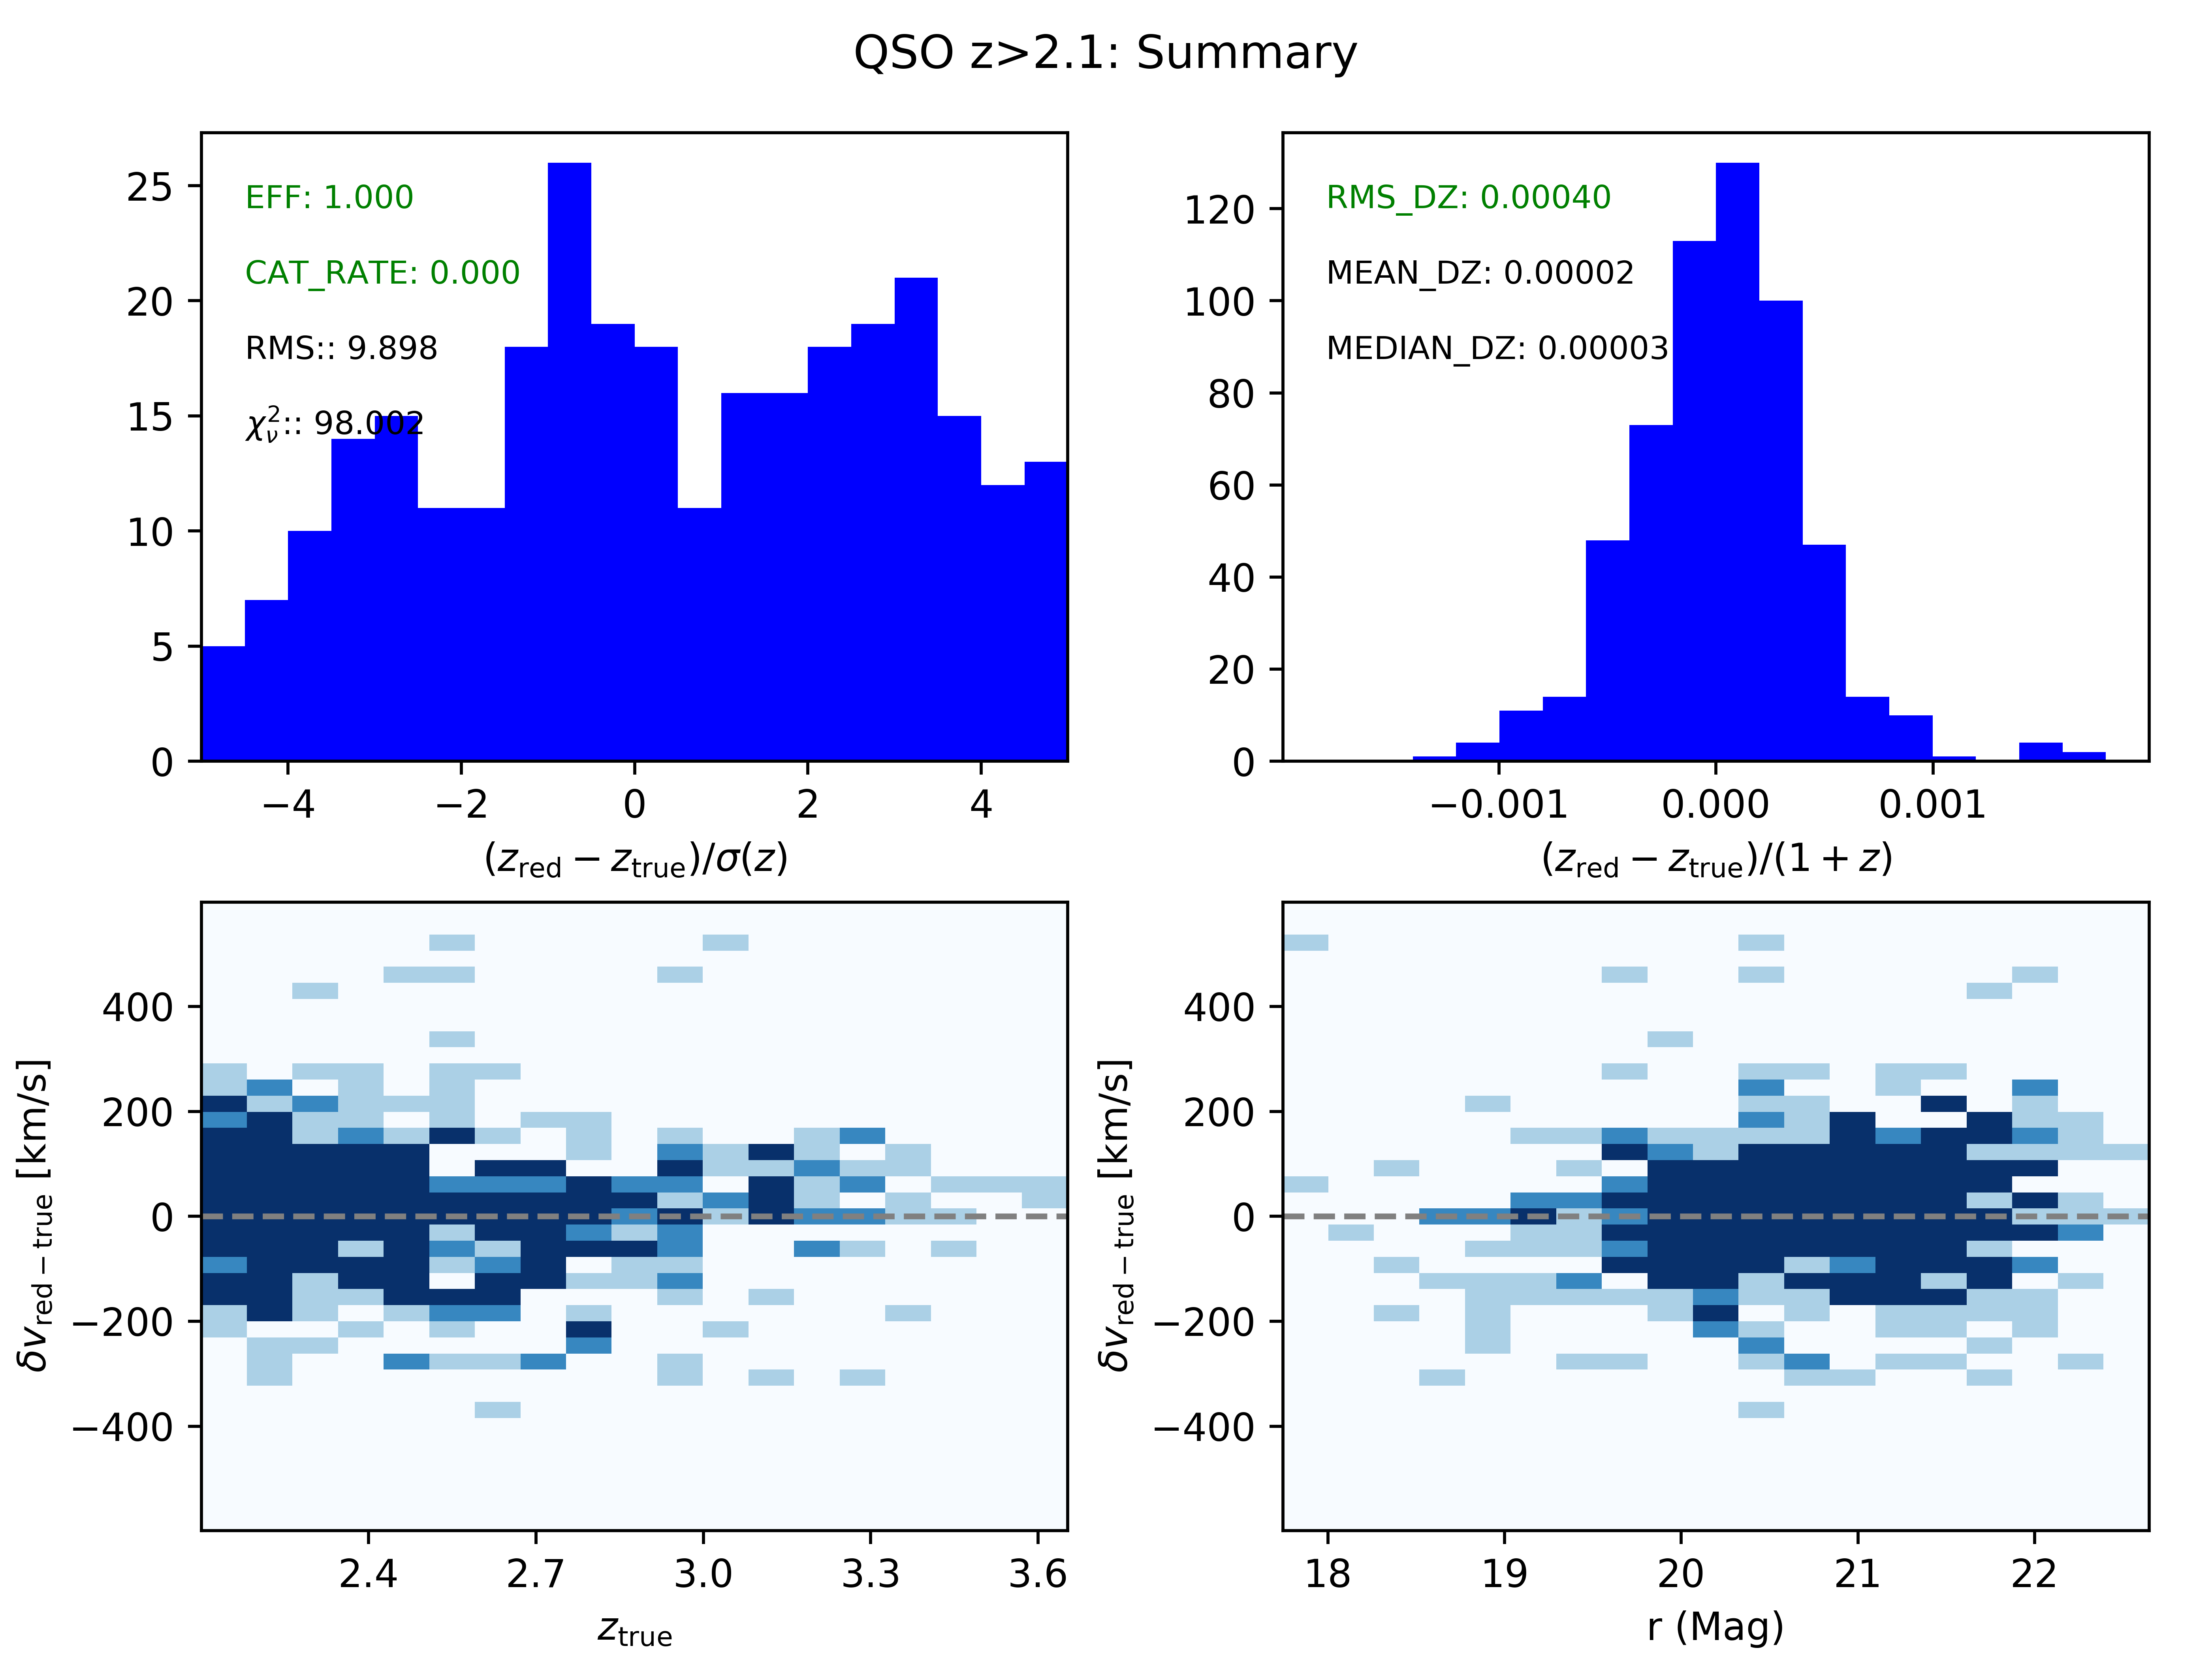

In [78]:
display(
    Image(filename=qaprod_dir+'/QA_zfind_QSO_T.png', width=500),
    Image(filename=qaprod_dir+'/QA_zfind_QSO_L.png', width=500),
)

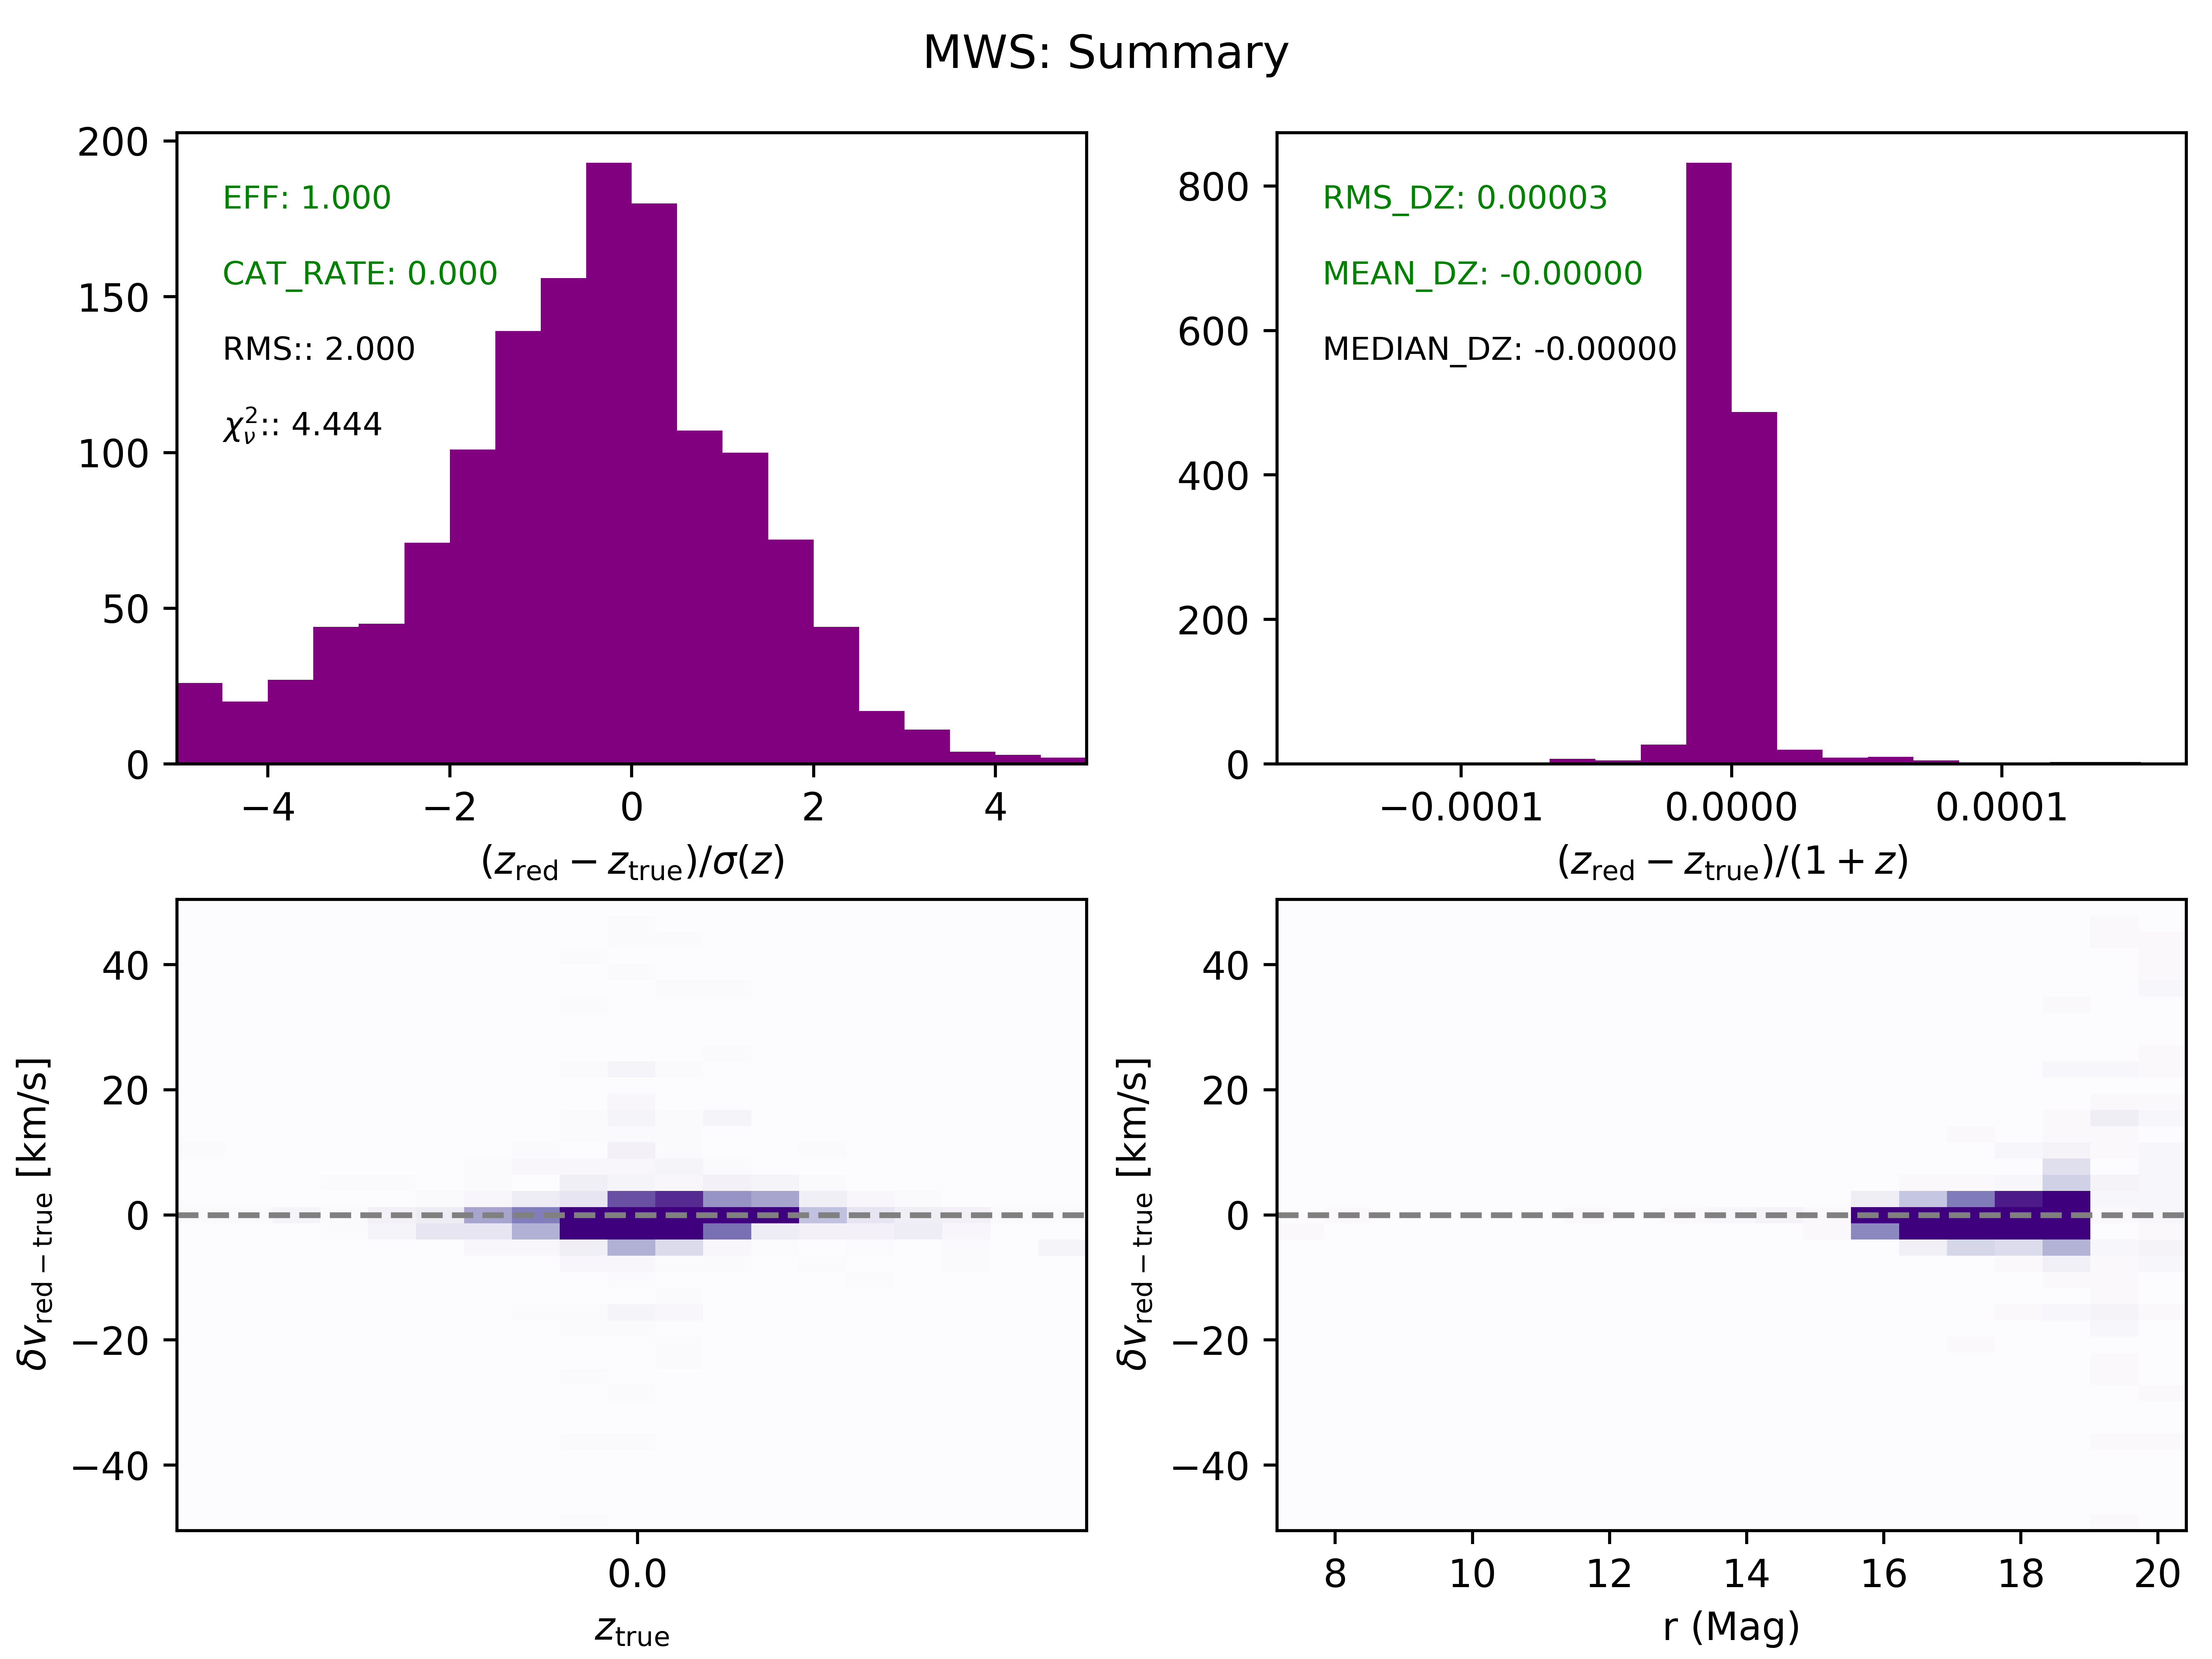

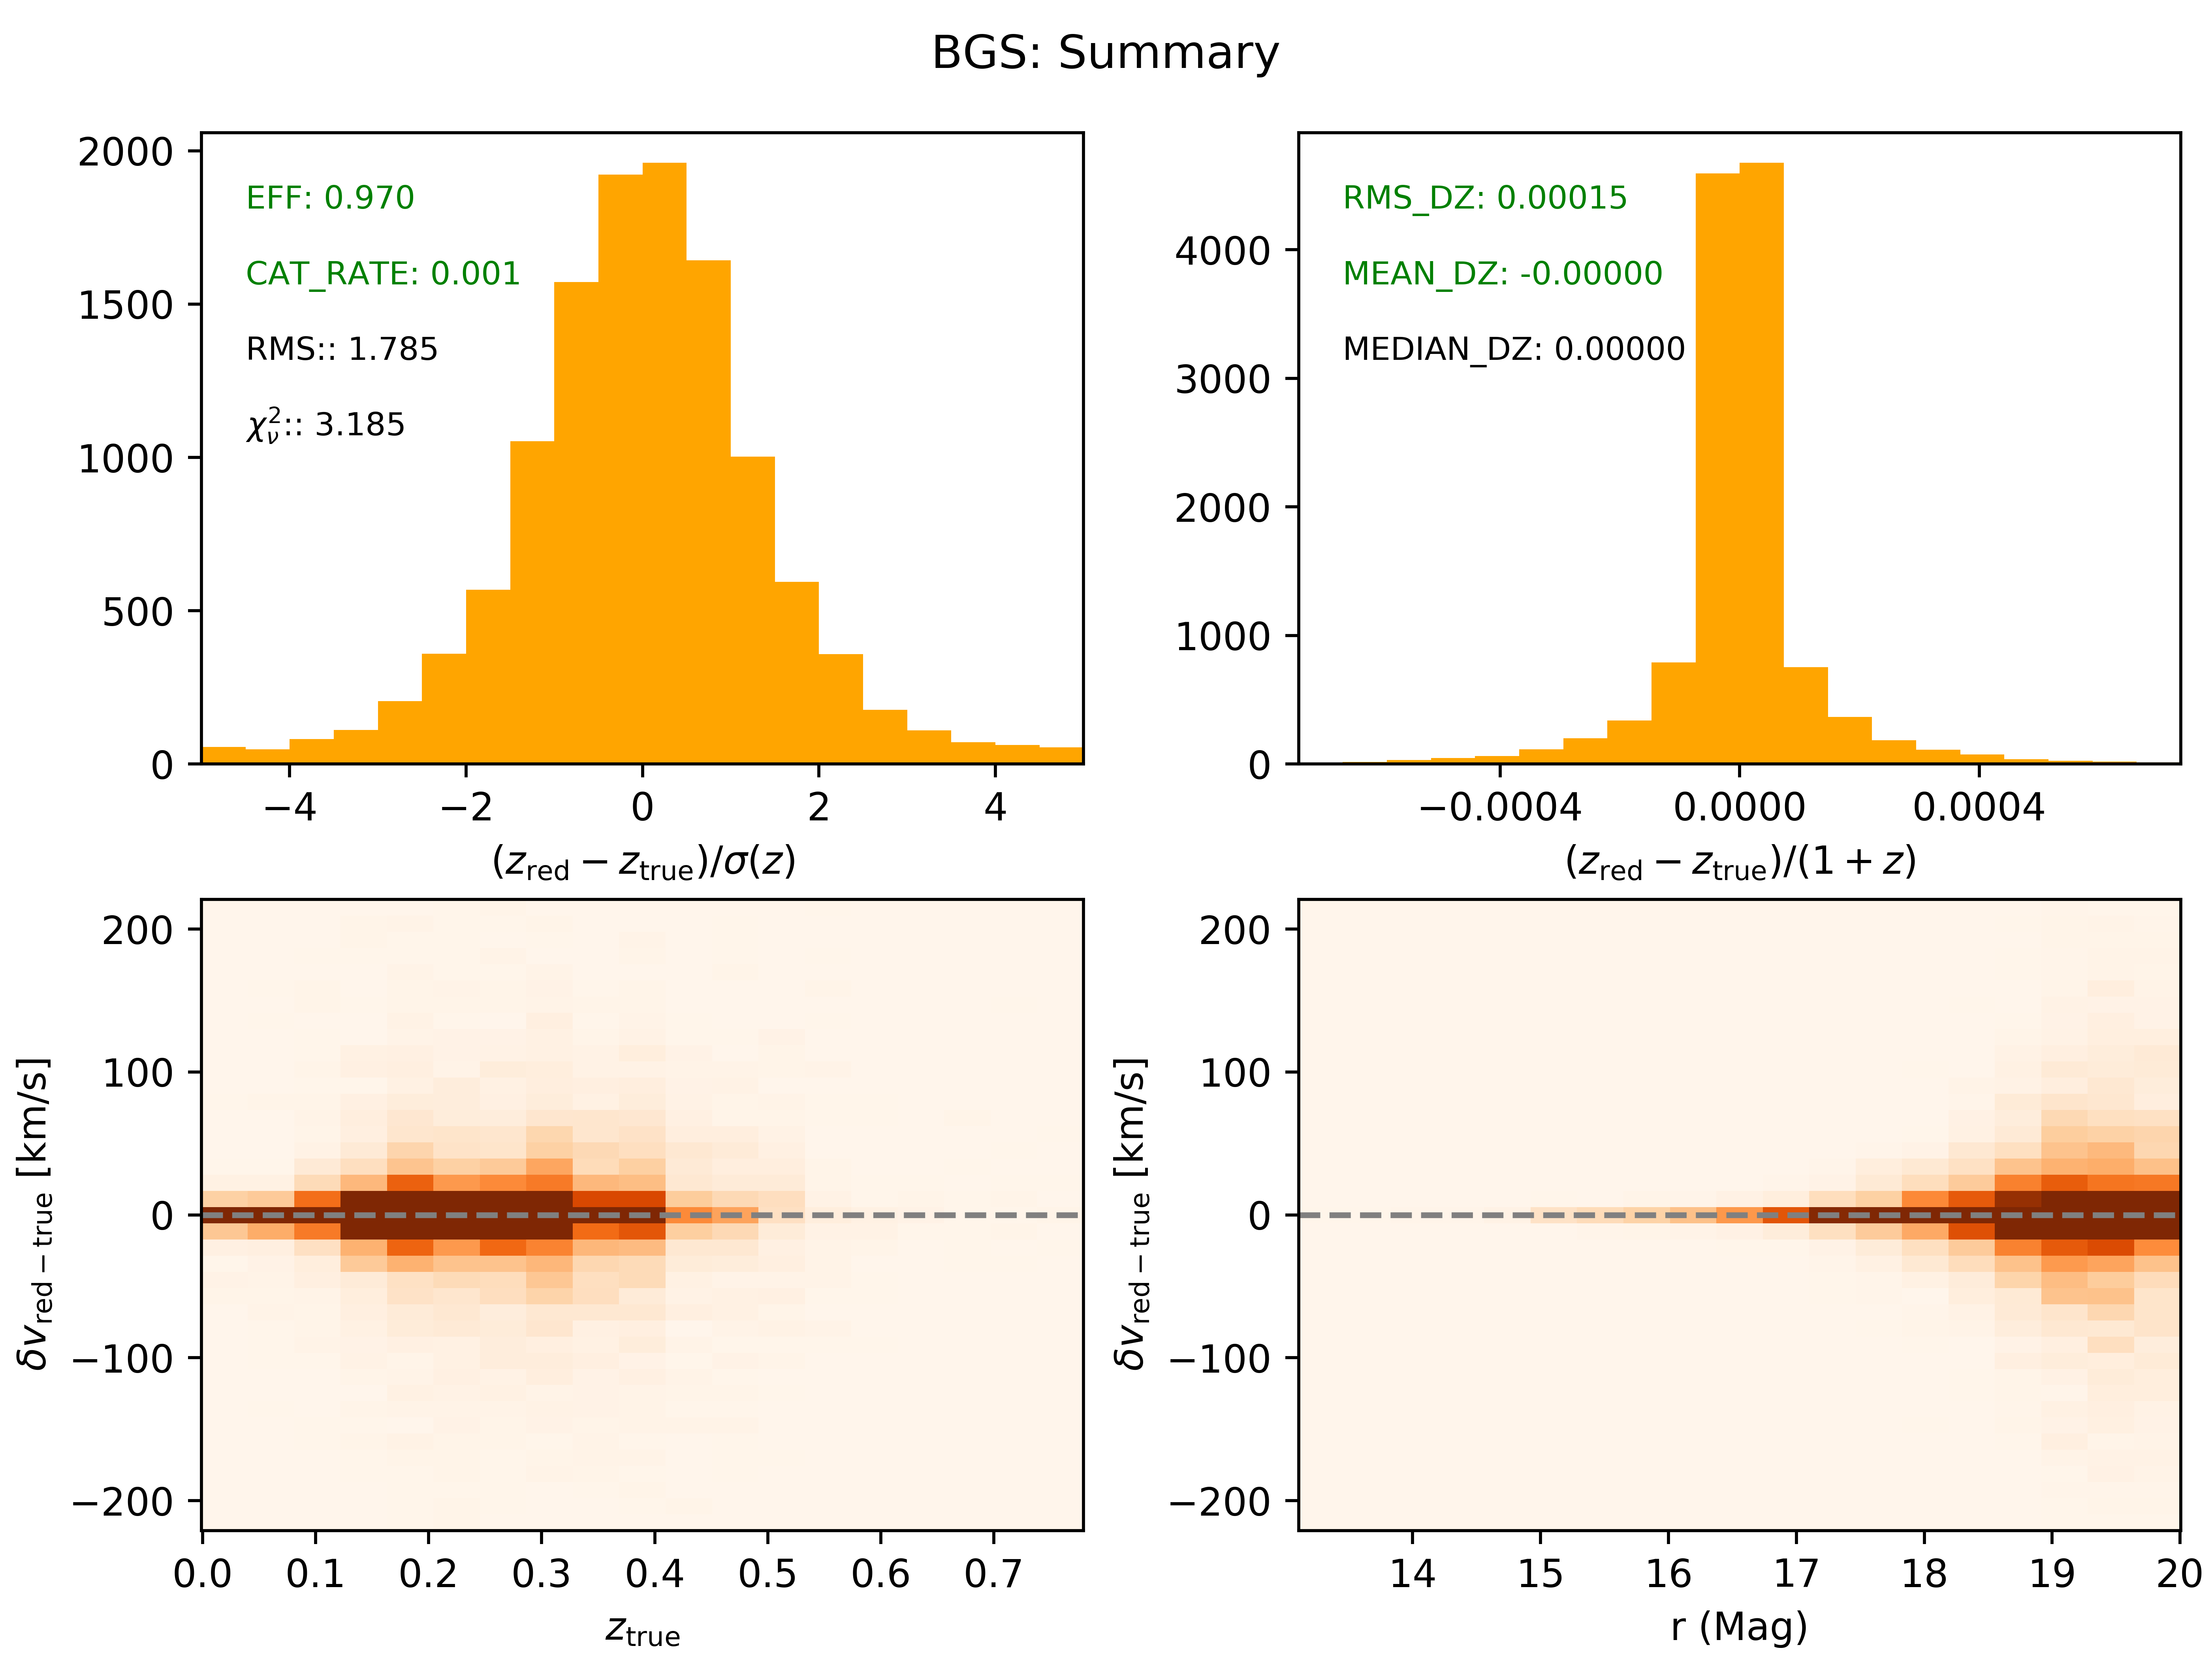

In [79]:
display(
    Image(filename=qaprod_dir+'/QA_zfind_MWS.png', width=500),
    Image(filename=qaprod_dir+'/QA_zfind_BGS.png', width=500),
)

In [80]:
print("Timing checkpoint at {}".format(time.asctime()))
tmp_time = time.time() - notebook_start_time
print("{:.1f} minutes so far".format(tmp_time/60))

Timing checkpoint at Thu Feb 28 22:07:16 2019
325.4 minutes so far
